In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import spline, interp1d
from scipy.optimize import fsolve

In [2]:
# fully open gate height estimated from diagram on source 4
print('Gate dimensions at "empty" dam (30m) and fully open gate:')
GateHeight = (503-476)/2
print('   Gate Height =',round(GateHeight,2),'m')
GateFlowArea = 3.84405**2 # m^2 so that flow rate maxes at 358.5 m^3/s
GateWidth = GateFlowArea/GateHeight
print('   Gate Width =',round(GateWidth,4),'m')
def FlowRate(h,Δz):
    # h  = height of opening of the gate valve
    # Δz = dam depth can range from 30 to 220 m
    # returns the flow rate (q)
    width = GateWidth #m
    A = h*width
    g = 9.81 # m/s^2
    v = np.sqrt(2*g*Δz) # m/s - velocity of water
    q = A*v # flow rate through gate maxes at 358.5 m^3/s
    return q
print('   Max Flow rate =',round(FlowRate(13.5,30),2),'m^3/s')

Gate dimensions at "empty" dam (30m) and fully open gate:
   Gate Height = 13.5 m
   Gate Width = 1.0946 m
   Max Flow rate = 358.5 m^3/s


In [49]:
def PowerOut(h,Δz):
    # This function give the power output given the height of the
    #     gate's opening, and depth of the dam
    # returns power output in MW
    
    q = FlowRate(h,Δz)
    g = 9.81 # m/s^2
    
    # efficiency found using max rated flowrate (358.5 m^3/s)
    # and rated output (640 MW)
    η = .8286
    
    ρ = 998.29 # kg/m^3 - density of water at 20°C
    W_dam = ρ*g*q*Δz # Energy from dam hydrostatic pressure
    W_head = 0#ρ*g*q*194 # Energy from 194 m head between gate and turbine
    return η*(W_dam+W_head) / 10**6

print('At maximum gate opening and "empty" dam (30m):')
print('   Max power output =',round(PowerOut(13.5,30),2),'MW')

At maximum gate opening and "empty" dam (30m):
   Max power output = 87.27 MW


In [50]:
def FindOperatingHeights(Δz):
    # Need to change the gate height depending on the Dam Level
    #   in order to maintain within operating zones for turbine
    
    def HiMx(h):
        return PowerOut(h,Δz)-640.0
    HighMax = fsolve(HiMx,8)[0]
    if HighMax > 13.5:
        HighMax = 13.5
    if HighMax < 0.0:
        HighMax = 0.0
    #print(HighMax)

    def HiLo(h):
        return PowerOut(h,Δz)-550.0
    HighLow = fsolve(HiLo,8)[0]
    if HighLow > 13.5:
        HighLow = 13.5
    if HighLow < 0:
        HighLow = 0.0
    #print(HighLow)

    def LoMx(h):
        return PowerOut(h,Δz)-350.0
    LowMax = fsolve(LoMx,3)[0]
    if LowMax > 13.5:
        LowMax = 13.5
    if LowMax < 0:
        LowMax = 0.0
    #print(LowMax)

    def LoLo(h):
        return PowerOut(h,Δz)-0.0
    LowLow = fsolve(LoLo,3)[0]
    if LowLow > 13.5:
        LowLow = 13.5
    if LowLow < 0:
        LowLow = 0.0
    #print(LowLow)
    
    return [HighMax,HighLow,LowMax,LowLow]

The dam level changes throughout the year


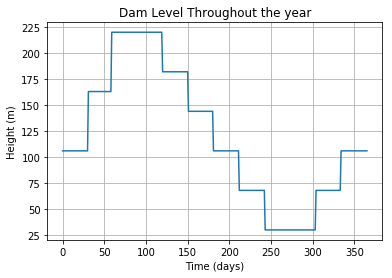

Based on the energy balance, the colored zones are the height the gate can be open in safe operating conditions


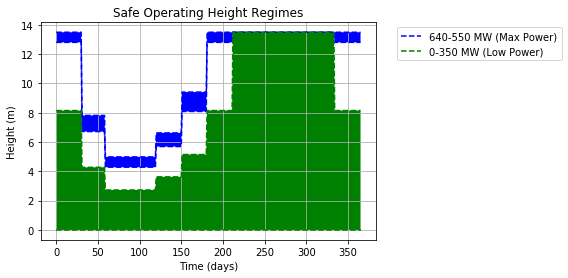

We want to operate in the max power regime.  So the set point is averaged between the top and bottom values of the max power regime


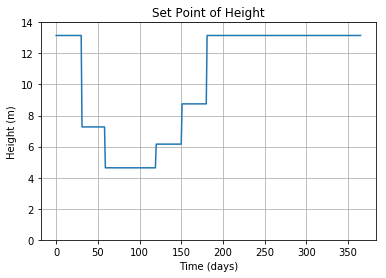

In [51]:
# Step function of dam level
ndays = 365
ns = ndays
#DamLevel = np.array([106,163,220,220,182,144,106,68,30,30,68,106])
DamLevel = np.ones(ndays+1)
DamLevel[0:31] *= 106
DamLevel[31:59] *= 163
DamLevel[59:90] *= 220
DamLevel[90:120] *= 220
DamLevel[120:151] *= 182
DamLevel[151:181] *= 144
DamLevel[181:212] *= 106
DamLevel[212:243] *= 68
DamLevel[243:273] *= 30
DamLevel[273:304] *= 30
DamLevel[304:334] *= 68
DamLevel[334:366] *= 106

# Find Operating Limits to graph
TopMax = np.ones(len(DamLevel))
TopLow = np.ones(len(DamLevel))
BotMax = np.ones(len(DamLevel))
BotLow = np.ones(len(DamLevel))
for i in range(len(DamLevel)):
    #print(i)
    z = DamLevel[i]
    values = FindOperatingHeights(z)
    TopMax[i] = values[0]
    TopLow[i] = values[1]
    BotMax[i] = values[2]
    BotLow[i] = values[3]

ts = np.linspace(0,ndays,ndays+1) # Each day of the year

print('The dam level changes throughout the year')
plt.grid()
plt.title('Dam Level Throughout the year')
plt.plot(ts,DamLevel,label='Dam Level')
plt.xlabel('Time (days)')
plt.ylabel('Height (m)')
plt.show()

print('Based on the energy balance, the colored zones are the height the gate can be open in safe operating conditions')
plt.grid()
plt.title('Safe Operating Height Regimes')
plt.plot(ts,TopMax,'--b',label='640-550 MW (Max Power)')
plt.plot(ts,TopLow,'--b')
plt.fill(np.append(ts, ts[::-1]), np.append(TopMax, TopLow[::-1]), 'b')
plt.plot(ts,BotMax,'--g',label='0-350 MW (Low Power)')
plt.plot(ts,BotLow,'--g')
plt.fill(np.append(ts, ts[::-1]), np.append(BotMax, BotLow[::-1]), 'g')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (days)')
plt.ylabel('Height (m)')
plt.show()

# Generate simulated process data
setPoint = (TopMax+TopLow)/2
for i in range (len(TopMax)):
    if setPoint[i] == TopMax[i]:
        setPoint[i] = setPoint[i-1]
#tsnew = np.linspace(0,ndays,2*ndays)
#newHeightSim = spline(ts,avgHeight,tsnew)
#process = avgHeight#newHeightSim + .01*np.sin(tsnew)

print('We want to operate in the max power regime.  So the set point is averaged between the top and bottom values of the max power regime')
plt.grid()
plt.title('Set Point of Height')
plt.plot(ts,setPoint)
plt.xlabel('Time (days)')
plt.ylabel('Height (m)')
plt.ylim(0,14)
plt.show()

Simulated Power Output based on the set point data and dam level


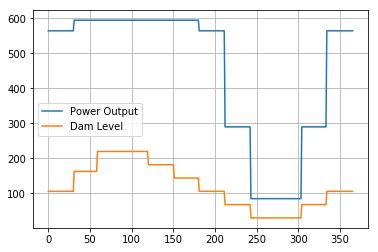

IAE = 21.207450252265012


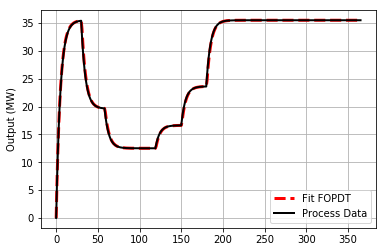

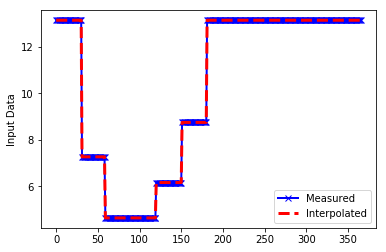

Km = 2.7 
taum = 4.9 
thetam = 0.0
IAE was minimized manually by altering Km, taum, and thetam.


In [90]:
# define process model (to generate process data)
def process(y,t,n,u,Kp,taup):
    # arguments
    #  y[n] = outputs - MW
    #  t    = time
    #  dz   = Dam Level
    #  n    = order of the system  
    #  u    = input value
    #  Kp   = process gain
    #  taup = process time constant
    
    # equations for higher order system
    dydt = np.zeros(n)
    # calculate derivative
    dydt[0] = (-y[0] + Kp * u)/(taup/n)
    for i in range(1,n):
       dydt[i] = (y[i] + y[i-1])/(taup/n)
    return dydt

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = 0
    # calculate derivative
    dydt = (-y + Km * um)/taum
    return dydt

# specify number of steps
ns = ndays #40
# define time points
t = np.linspace(0,ns,ns+1)
delta_t = t[1]-t[0]
# define input vector - set point data
u = setPoint#np.zeros(ns+1)
#u[5:] = 1.0
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# use this function or replace yp with real process data
print('Simulated Power Output based on the set point data and dam level')
def sim_process_data():
    # higher order process
    n=1       # order was 10 in source code
    Kp=2.7    # gain
    taup=5.0   # time constant
    # storage for predictions or data
    yp = np.zeros(ns+1)  # process
    yp1 = np.zeros(ns+1)
    for i in range(ns+1):
        yp1[i] = PowerOut(setPoint[i],DamLevel[i])
    for i in range(1,ns+1):
        if i==1:
            yp0 = yp[0]
        ts = [delta_t*(i-1),delta_t*i]
        y = odeint(process,yp0,ts,args=(n,u[i],Kp,taup))
        yp0 = y[-1]
        yp[i] = y[1][n-1]
        #print(len(yp))
    return yp,yp1
yp = sim_process_data()[0]
yp1 = sim_process_data()[1]
plt.grid()
plt.plot(ts,yp1,label='Power Output')
plt.plot(ts,DamLevel,label='Dam Level')
plt.legend()
plt.show()

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(Km,taum,thetam):
    # input arguments
    #Km
    #taum
    #thetam
    # storage for model values
    ym = np.zeros(ns+1)  # model
    # initial condition
    ym[0] = 0
    # loop through time steps    
    for i in range(1,ns+1):
        ts = [delta_t*(i-1),delta_t*i]
        y1 = odeint(fopdt,ym[i-1],ts,args=(uf,Km,taum,thetam))
        ym[i] = y1[-1]
    return ym    

# calculate model with updated parameters
Km = 2.7
taum = 4.9
thetam = 0.0
ym = sim_model(Km,taum,thetam)

# Integral Absolute Error
iae = 0
for i in range(len(ym)):
    iae += np.abs(ym[i]-yp[i])
print('IAE =',iae)

# plot results
plt.grid()
#plt.subplot(2,1,1)
plt.plot(t,ym,'r--',linewidth=3,label='Fit FOPDT')
plt.plot(t,yp,'k-',linewidth=2,label='Process Data')
plt.ylabel('Output (MW)')
plt.legend(loc='best')
plt.show()
#plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()

print('Km =',Km,'\ntaum =',taum,'\nthetam =',thetam)
print('IAE was minimized manually by altering Km, taum, and thetam.')